In [ ]:
import shutil

Read in TGZ Folder that contains the first pitch, second pitch, and third pitch data for each pitcher

In [ ]:
filename='/content/pitch_folder_all.tgz'
dir='/content'
shutil.unpack_archive(filename,dir)

In [ ]:
pip install np_utils

In [ ]:
import pandas as pd

In [ ]:
fps=pd.read_csv('/content/pitch_folder/alldata_p1.csv')
sp=pd.read_csv('/content/pitch_folder/alldata_p2.csv')
tp=pd.read_csv('/content/pitch_folder/alldata_p3.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (87,88) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The only_first_pitch_strikes method:

Parameters: a dataframe.

The method will constrain the dataframe such that it only returns pitches which resulted in a strike. This contrainst is necessary since I wish to predict sequences only in which the first pitch was a strike

Return: New Dataframe that contains only strikes

In [ ]:
def only_first_pitch_strikes(df):
  df=df[(df.description=='swinging_strike') | 
                                      (df.description=='called_strike') |
                                      (df.description=='swinging_strike_blocked') | 
                                      (df.description=='foul') |
                                      (df.description=='foul_bunt') ]
  return df
                                


In [ ]:
fps=only_first_pitch_strikes(fps)

the unique_at_bat_id method

parameter: dataframe

This method creates the unique at bat id feature within each pitch. It is a combination of various features,
with the intent to create a unique identifier for a sequence. It is assured that each pitch in each
dataframe will have existed in the same sequence since each pitch in the sequence, across
dataframes, will contain the same unqieu at bat id

Returns: New Dataframe

In [ ]:
def unique_at_bat_id(df):
  df['at_bat_id']=df['player_name'] + '_' + df['game_date']+'_'+df['batter'].astype(str)+'_'+df['on_3b'].astype(str)+'_'+df['on_2b'].astype(str)+'_'+df['on_1b'].astype(str)+'_'+df['outs_when_up'].astype(str)+'_'+df['inning'].astype(str)+'_'+df['inning_topbot'].astype(str) + '_' + df['home_score'].astype(str) + '_' + df['away_score'].astype(str) + '_' + df['home_team'] + '_' + df['away_team']
  return df


In [ ]:
for df in [fps,sp,tp]:
  df=unique_at_bat_id(df)

Ensure that my sequence datapoints only contain the relevant features I am interested in

In [ ]:
fps=fps[['pitch_type','release_speed','zone','at_bat_id', 'release_spin_rate','release_extension','player_name']]
sp=sp[['pitch_type','release_speed','zone','at_bat_id','release_spin_rate','release_extension','player_name']]
tp=tp[['pitch_type','release_speed','zone','at_bat_id','release_spin_rate','release_extension','player_name']]


Merge dataframes: I merge the dataframes on the unique at_bat_id feature that each pitch contains so each sequence's rows line up to be of the same overall sequence

In [ ]:
#begin new test format
sequence_1=fps.merge(tp,on=['at_bat_id'])
sequence_3=tp.merge(fps,on=['at_bat_id'])
sequence_2=sp.merge(sequence_3,on=['at_bat_id'])

print(len(sequence_1))
print(len(sequence_2))
print(len(sequence_3))

10735
10735
10735


In [ ]:
sequence_1=sequence_1[['pitch_type_x','release_speed_x','zone_x','release_spin_rate_x','release_extension_x','player_name_x']]
sequence_2=sequence_2[['pitch_type','release_speed','zone','release_spin_rate','release_extension','player_name']]
sequence_3=sequence_3[['pitch_type_x','release_speed_x','zone_x','release_spin_rate_x','release_extension_x','player_name_x']]



Drop all rows in which the pitch type is 'PO'

The 'PO' value stands for the pitch type 'pitch-outs'

Pitch outs are extremely rare and I drop all sequences that contain this pitch type. 

In [ ]:
po_locs=sequence_3.index[sequence_3['pitch_type_x']=='PO'].tolist()
for val in po_locs:
  sequence_1.drop(val,axis=0,inplace=True)
  sequence_2.drop(val,axis=0,inplace=True)
  sequence_3.drop(val,axis=0,inplace=True)



In [ ]:
sequence_1.reset_index(drop=True)
sequence_2.reset_index(drop=True)
sequence_3.reset_index(drop=True)

,pitch_type_x,release_speed_x,zone_x,release_spin_rate_x,release_extension_x,player_name_x
0,SI,88.7,12.0,2171.0,6.1,Rick Porcello
1,SI,91.0,14.0,2097.0,6.3,Rick Porcello
2,SI,91.3,12.0,2015.0,6.2,Rick Porcello
3,SI,90.8,14.0,2238.0,6.1,Rick Porcello
4,CH,81.6,14.0,1578.0,6.0,Rick Porcello
...,...,...,...,...,...,...
10726,FF,95.1,NaN,NaN,NaN,Justin Verlander
10727,SL,81.8,58.0,NaN,NaN,Rick Porcello
10728,FF,92.4,51.0,NaN,NaN,Rick Porcello
10729,FT,92.8,25.0,NaN,NaN,Rick Porcello


Collect the rows in each pitch sequence that contain nan values. I collect the non-duplicate ones since two of the same rows in different dataframes could both contain NaN values. If I did not account for duplicates, I would be attempting to drop a row that was already dropped

In [ ]:
nan_locs_1=sequence_1[sequence_1.isna().any(axis=1)].index.tolist()
nan_locs_2=sequence_2[sequence_2.isna().any(axis=1)].index.tolist()
nan_locs_3=sequence_3[sequence_3.isna().any(axis=1)].index.tolist()
nan_locs_all=nan_locs_1+nan_locs_2+nan_locs_3
nan_no_duplicates=[]
[nan_no_duplicates.append(x) for x in nan_locs_all if x not in nan_no_duplicates]
print(nan_no_duplicates)

[408, 655, 677, 678, 679, 680, 681, 812, 1342, 1344, 1345, 1346, 1348, 1349, 1354, 1355, 1356, 1357, 1358, 1366, 1519, 1661, 1662, 1663, 1664, 2931, 3490, 3610, 4061, 4063, 4164, 4168, 4203, 4409, 4410, 4543, 4547, 4565, 4614, 4643, 4644, 4803, 4804, 4891, 4892, 4894, 4895, 4919, 4920, 4949, 4950, 5040, 5056, 5066, 5100, 5105, 5144, 5181, 5191, 5240, 5253, 5260, 5307, 5333, 5337, 5353, 5361, 5377, 5383, 5395, 5433, 5470, 5471, 5475, 5484, 5516, 5554, 5595, 5596, 5674, 5777, 5786, 5804, 5806, 5807, 5833, 5840, 5937, 5997, 6037, 6048, 6096, 6097, 6138, 6154, 6163, 6203, 6204, 6241, 6243, 6244, 6265, 6314, 6315, 6334, 6358, 6375, 6406, 6430, 6440, 6451, 6464, 6465, 6494, 6511, 6534, 6535, 6550, 6551, 6582, 6623, 6624, 6626, 6647, 6651, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736,

Drop all sequences that contain nan values

In [ ]:
for row in nan_no_duplicates:
  sequence_1.drop(row,axis=0,inplace=True)
  sequence_2.drop(row,axis=0,inplace=True)
  sequence_3.drop(row,axis=0,inplace=True)


In [ ]:
sequence_1.reset_index(drop=True)
sequence_2.reset_index(drop=True)
sequence_3.reset_index(drop=True)

,pitch_type_x,release_speed_x,zone_x,release_spin_rate_x,release_extension_x,player_name_x
0,SI,88.7,12.0,2171.0,6.1,Rick Porcello
1,SI,91.0,14.0,2097.0,6.3,Rick Porcello
2,SI,91.3,12.0,2015.0,6.2,Rick Porcello
3,SI,90.8,14.0,2238.0,6.1,Rick Porcello
4,CH,81.6,14.0,1578.0,6.0,Rick Porcello
...,...,...,...,...,...,...
6284,SL,92.4,14.0,2503.0,5.7,Jake Arrieta
6285,FF,94.0,3.0,2249.0,6.0,Jake Arrieta
6286,SI,94.0,6.0,2229.0,6.5,Jake Arrieta
6287,FT,93.3,8.0,2496.0,6.5,Rick Porcello


       pitch_type  pitch_speed  pitch_loc  pitch_spin_rates
0             0.5     0.634078  -1.795137         -0.002000
1             0.6     0.594972  -1.796230          0.000091
2             0.5     0.664804  -1.794279         -0.001696
3             0.5     0.664804  -1.794279         -0.002554
4             0.6     0.581006  -1.796620         -0.000728
...           ...          ...        ...               ...
18862         0.5     0.751397  -1.791860          0.001246
18863         0.5     0.793296  -1.790690          0.000840
18864         0.3     0.740223  -1.792173          0.002557
18865         0.5     0.751397  -1.791860          0.001246
18866         0.6     0.614525  -1.795684         -0.010427

[18867 rows x 4 columns]


This code block sets all Knuckle-Curve pitch types to Curveball pitch types. I found it redundant to consider these differing classifications, as the Knuckle Curve is a type of curveball with a slightly different grip. Furthermore, in the Eck paper, knuckle curves and curveballs are considered the same pitch when calculating pitcher similarity. The possible pitch types are:

FS: Split Finger Fastball
FC: Cut Fastball
SL: Slider
FF: 4 Seam Fastball
FT: Two Seam Fastball
CH: Changeup
CU: Curveball

In [ ]:
import sklearn
from sklearn import preprocessing

In [ ]:
sequence_1.loc[(sequence_1.pitch_type_x == 'KC'),'pitch_type_x']='CU'
sequence_2.loc[(sequence_2.pitch_type == 'KC'),'pitch_type']='CU'
sequence_3.loc[(sequence_3.pitch_type_x == 'KC'),'pitch_type_x']='CU'
pitches1=list((sequence_1['pitch_type_x']))
pitches2=list((sequence_2['pitch_type']))
pitches3=list((sequence_3['pitch_type_x']))
pitches=pitches1+pitches2+pitches3
labels=set(pitches)
print(labels)


{'SI', 'CH', 'FC', 'FT', 'FF', 'SL', 'CU', 'FS'}


Collapse the individual pitch sequence dataframes into one dataframe. Each 3 elements of the pitches, pitch_velos, pitch_locations, pitch_spin, pitch_extension arrays correspond to one 3 pitch sequence. I then collapse all of these arrays into one dataframe. 

In [ ]:
import numpy as np
pitches=[None] * (3 * len(sequence_1['pitch_type_x']))
pitch_velos=[None] * (3*len(sequence_1['release_speed_x']))
pitch_locations=[None] * (3*len(sequence_1['zone_x']))
pitch_spin=[None] * (3*len(sequence_1['release_spin_rate_x']))
j=0
for i in range(0,len(pitches),3):
  pitches[i]=(sequence_1['pitch_type_x'][i-(2*j)])
  pitch_velos[i]=(sequence_1['release_speed_x'][i-(2*j)])
  pitch_spin[i]=sequence_1['release_spin_rate_x'][i-(2*j)]
  pitch_locations[i]=(sequence_1['zone_x'][i-(2*j)])
  pitches[i+1]=(sequence_2['pitch_type'][i-(2*j)])
  pitch_velos[i+1]=(sequence_2['release_speed'][i-(2*j)])
  pitch_spin[i+1]=sequence_2['release_spin_rate'][i-(2*j)]
  pitch_locations[i+1]=(sequence_2['zone'][i-(2*j)])
  pitches[i+2]=(sequence_3['pitch_type_x'][i-(2*j)])
  pitch_velos[i+2]=(sequence_3['release_speed_x'][i-(2*j)])
  pitch_locations[i+2]=(sequence_3['zone_x'][i-(2*j)])
  pitch_spin[i+2]=sequence_3['release_spin_rate_x'][i-(2*j)]
  j=j+1

pitch_data_frame=pd.DataFrame({
      'pitch_type':pitches,
     'pitch_speed':pitch_velos,
     'pitch_loc':pitch_locations,
     'pitch_spin_rates':pitch_spin}
)
input_length=len(pitch_data_frame['pitch_speed']) * 1/3
output_length=len(pitch_data_frame['pitch_speed']) * 1/3
input_length=int(input_length)
input=np.ndarray(shape=(input_length,8))
output=[]


KeyError: ignored

Data Encoding:

I use the min/max scaler to encode my numerical features, and I used the preprocessing LabelEncoder() tool to encode my categorical features, which are the pitch types. I then reset the respective data frame columns for each feature back to these scaled features. I scale all my features to exist in the range [-1,1]

In [ ]:
all_pitches=pitch_data_frame['pitch_type']
le=preprocessing.LabelEncoder()
le.fit(all_pitches)
all_pitches=le.transform(all_pitches)
all_pitches=all_pitches.astype(float)
for val in range(len(all_pitches)):
  all_pitches[val]=(all_pitches[val])/10
pitch_data_frame['pitch_type']=all_pitches

In [ ]:

speeds=np.asarray(pitch_data_frame['pitch_speed'])
speeds=speeds.reshape(-1,1)
ms=MinMaxScaler(feature_range=(0,1))
ms.fit(speeds)
speeds=ms.transform(speeds)
pitch_data_frame['pitch_speed']=speeds

In [ ]:
print(pitch_data_frame)

       pitch_type  pitch_speed  pitch_loc  pitch_spin_rates
0             0.5     0.634078        2.0            2132.0
1             0.6     0.594972       14.0            2400.0
2             0.5     0.664804       12.0            2171.0
3             0.5     0.664804        6.0            2061.0
4             0.6     0.581006       12.0            2295.0
...           ...          ...        ...               ...
18862         0.5     0.751397       13.0            2548.0
18863         0.5     0.793296        8.0            2496.0
18864         0.3     0.740223       12.0            2716.0
18865         0.5     0.751397       13.0            2548.0
18866         0.6     0.614525       11.0            1052.0

[18867 rows x 4 columns]


In [ ]:
spin_rates=np.asarray(pitch_data_frame['pitch_spin_rates'])
spin_rates=spin_rates.reshape(-1,1)
ms2=MinMaxScaler(feature_range=(0,1))
ms2.fit(spin_rates)
spin_rates=ms.transform(spin_rates)
spin_rates=spin_rates.astype(float)
for val in range(len(spin_rates)):
  spin_rates[val]=(spin_rates[val]/100)
pitch_data_frame['pitch_spin_rates']=spin_rates

In [ ]:
print(pitch_data_frame)

       pitch_type  pitch_speed  pitch_loc  pitch_spin_rates
0             0.5     0.634078        2.0         -0.002000
1             0.6     0.594972       14.0          0.000091
2             0.5     0.664804       12.0         -0.001696
3             0.5     0.664804        6.0         -0.002554
4             0.6     0.581006       12.0         -0.000728
...           ...          ...        ...               ...
18862         0.5     0.751397       13.0          0.001246
18863         0.5     0.793296        8.0          0.000840
18864         0.3     0.740223       12.0          0.002557
18865         0.5     0.751397       13.0          0.001246
18866         0.6     0.614525       11.0         -0.010427

[18867 rows x 4 columns]


In [ ]:
locs=np.asarray(pitch_data_frame['pitch_loc'])
locs=speeds.reshape(-1,1)
ms3=MinMaxScaler(feature_range=(0,1))
ms3.fit(locs)
locs=ms.transform(speeds)
pitch_data_frame['pitch_loc']=locs

       pitch_type  pitch_speed  pitch_loc  pitch_spin_rates
0             0.5     0.634078  -1.795137         -0.002000
1             0.6     0.594972  -1.796230          0.000091
2             0.5     0.664804  -1.794279         -0.001696
3             0.5     0.664804  -1.794279         -0.002554
4             0.6     0.581006  -1.796620         -0.000728
...           ...          ...        ...               ...
18862         0.5     0.751397  -1.791860          0.001246
18863         0.5     0.793296  -1.790690          0.000840
18864         0.3     0.740223  -1.792173          0.002557
18865         0.5     0.751397  -1.791860          0.001246
18866         0.6     0.614525  -1.795684         -0.010427

[18867 rows x 4 columns]


From my dataframe of 3-pitch sequences (pitch_data_frame), I now create my input/output arrays. My input arrays orresponds to the flattened datapoints of the first two pitches of a sequence. The output corresponds to the pitch type of the third pitch of the sequence.

Since I must use one-hot encoding for my output, I rescale my one-hot encoded pitch type feature back to it's original scale (I had it divided by 10 before)

In [ ]:
i=0
for j in range(0,(pitch_data_frame.shape[0]-1),3):
  k=0
  for val in pitch_data_frame.iloc[j]:
    input[i][k]=val
    k=k+1
  for val in pitch_data_frame.iloc[j+1]:
    input[i][k]=val
    k=k+1
  scaled_pitch_val=((pitch_data_frame.iloc[j+2]['pitch_type']))
  unscaled_pitch_val=(scaled_pitch_val*10).astype(int)
  output.append(unscaled_pitch_val)

  i=i+1



[5, 5, 5, 5, 0, 3, 6, 3, 1, 3, 3, 3, 1, 1, 3, 1, 6, 3, 3, 3, 6, 3, 3, 3, 6, 5, 3, 3, 6, 6, 5, 5, 5, 3, 0, 5, 0, 6, 3, 1, 3, 6, 6, 3, 3, 0, 3, 1, 3, 1, 6, 0, 6, 3, 3, 1, 3, 6, 5, 5, 6, 5, 6, 5, 0, 5, 6, 1, 3, 1, 0, 6, 5, 0, 6, 5, 3, 6, 3, 3, 0, 3, 0, 0, 1, 6, 0, 1, 6, 3, 1, 3, 6, 1, 3, 0, 6, 6, 5, 5, 3, 3, 3, 3, 6, 6, 3, 1, 6, 3, 1, 6, 3, 0, 6, 3, 0, 6, 3, 1, 5, 0, 1, 6, 5, 6, 5, 5, 1, 3, 6, 3, 6, 3, 1, 6, 3, 6, 3, 6, 6, 3, 5, 6, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 6, 3, 0, 3, 6, 3, 3, 3, 0, 6, 3, 1, 3, 6, 6, 1, 1, 1, 3, 0, 5, 1, 6, 1, 3, 3, 5, 5, 3, 6, 0, 6, 5, 6, 3, 0, 5, 3, 3, 1, 6, 3, 6, 6, 6, 3, 3, 5, 0, 6, 3, 6, 0, 6, 6, 3, 1, 1, 1, 5, 5, 6, 3, 3, 5, 3, 3, 5, 6, 6, 6, 4, 2, 4, 3, 5, 4, 3, 0, 5, 3, 6, 3, 6, 5, 3, 6, 1, 6, 0, 6, 1, 3, 4, 6, 2, 5, 1, 1, 3, 5, 5, 6, 0, 3, 3, 6, 1, 6, 1, 6, 1, 2, 3, 3, 3, 6, 5, 3, 3, 3, 6, 6, 6, 3, 3, 0, 3, 6, 3, 6, 3, 3, 1, 3, 3, 6, 6, 3, 3, 1, 6, 1, 6, 1, 1, 6, 6, 0, 3, 3, 6, 1, 6, 0, 3, 3, 1, 1, 1, 3, 1, 1, 1, 5, 5, 6, 3, 5, 3, 2, 4, 3, 3, 3, 6, 3, 5, 3, 

Learn the "vocab", or in other words, all the unique pitches that were thrown in all sequences. A dictionary is created that maps each word/pitch vector to a unique integer value

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(input,output,test_size=.25)


In [ ]:
import keras
import keras.utils
from keras.utils import to_categorical


In [ ]:
y_train=np.asarray(y_train)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)
y_test=np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)

Build and fit model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
lr=.0001


def make_model():
  inputs=tf.keras.Input(shape=(None,8))
  model=Sequential()
  model.add(Dense(20,activation='relu'))
  model.add(Dense(10,activation='relu'))
  model.add(Flatten())
  model.add(Dense(7,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer=Adam(lr),metrics=['accuracy'])
  return model
model=make_model()

In [ ]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=15)

Epoch 1/20
315/315 [==============================] - 1s 2ms/step - loss: 2.0066 - accuracy: 0.1975 - val_loss: 1.8084 - val_accuracy: 0.1914
Epoch 2/20
315/315 [==============================] - 0s 2ms/step - loss: 1.8100 - accuracy: 0.1940 - val_loss: 1.7128 - val_accuracy: 0.2409
Epoch 3/20
315/315 [==============================] - 0s 1ms/step - loss: 1.7219 - accuracy: 0.3186 - val_loss: 1.6714 - val_accuracy: 0.3986
Epoch 4/20
315/315 [==============================] - 0s 2ms/step - loss: 1.6879 - accuracy: 0.3811 - val_loss: 1.6410 - val_accuracy: 0.3992
Epoch 5/20
315/315 [==============================] - 0s 2ms/step - loss: 1.6568 - accuracy: 0.3790 - val_loss: 1.6205 - val_accuracy: 0.3992
Epoch 6/20
315/315 [==============================] - 0s 2ms/step - loss: 1.6475 - accuracy: 0.3769 - val_loss: 1.6066 - val_accuracy: 0.3992
Epoch 7/20
315/315 [==============================] - 0s 1ms/step - loss: 1.6507 - accuracy: 0.3681 - val_loss: 1.5973 - val_accuracy: 0.3992
Epoch 

In [ ]:
from matplotlib import pyplot as plt

Plot Loss/Accuracy

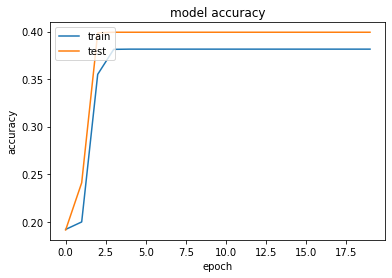

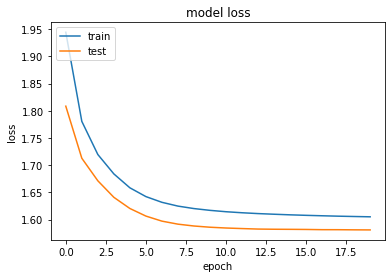

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluate Model's Performance using the KFolds Classifier tool, so as to avoid the chance my test/train sets were not representative of my data as a whole. Furthermore, I evaluate my model on it's loss/accuracy with respect to both my testing and training sets

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
output2=np_utils.to_categorical(output)
estimator = KerasClassifier(build_fn=make_model, epochs=30, batch_size=10, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, input, output2, cv=kfold)




In [ ]:
l,accuracy=model.evaluate(X_test,y_test)


50/50 [==============================] - 0s 1ms/step - loss: 1.5782 - accuracy: 0.3992


In [ ]:
l,accuracy=model.evaluate(X_train,y_train)

148/148 [==============================] - 0s 1ms/step - loss: 1.5966 - accuracy: 0.3815


In [ ]:
print("Model: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Model: 38.59% (1.65%)


In [ ]:
y_pred=model.predict(X_test).argmax(-1)
